# STEPS

1. Load data from Ergast. (Code from @NicolasThiel)
2. Merge tables to combine required data together, laptimes, raceID, driverID, constructorID.
3. For each season find the constructor with the fastest average lap time, account for retired drivers etc.
4. Then for each race in a season calculate the first and second fastest teams average lap time, if fastest team for that season is not one of those two then also compute their average lap time for the race. 
5. When the most dominant team was the fastest add their advantage to the gap between the teams, when they were not the fastest take away the difference to the fastest team. 

This should result in the average gap the fastest team had over the others for a season. Can show the data for all seasons.

In [1]:
import pandas as pd
import numpy as np
import statistics
import datetime
import requests
import zipfile
import io
import os

from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import pyplot as plt
import seaborn as sns

### Step 1: Load the data from Ergast!

In [2]:
# Define the URL for the zip file and the local filename to use
url = 'http://ergast.com/downloads/f1db_csv.zip'
filename = 'f1db_csv.zip'

# Create a data directory if it doesn't exist
if not os.path.exists('../data'):
    os.makedirs('../data')

# Download the zip file
response = requests.get(url)

# Unzip the file into the data directory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall('../data')

dataframes = {}

# Loop through the csv files in the data directory
for csv_file in os.listdir('../data'):
    if csv_file.endswith('.csv'):
        # Read the csv file into a dataframe 
        df_name = csv_file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(f'../data/{csv_file}')

In [3]:
# races
races = dataframes['races']
print(races.shape)
races.head()

(1102, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [4]:
# drivers
drivers = dataframes['drivers']
print(drivers.shape)
drivers.head()

(857, 9)


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
# lap times
lap_times = dataframes['lap_times']
print(lap_times.shape)
lap_times.head()

(543212, 6)


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [6]:
# results
results = dataframes['results']
print(results.shape)
results.head()

(25940, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [7]:
# constructors
constructors = dataframes['constructors']
print(constructors.shape)
constructors.head()

(211, 5)


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


### Step 2: Merge the dataframes!

In [8]:
lap_times_race_info = lap_times.merge(races[['raceId', 'year', 'name']], on='raceId')
lap_times_race_driver_info = lap_times_race_info.merge(drivers[['driverId', 'driverRef']], on='driverId')
lap_times_race_driver_team_info = lap_times_race_driver_info.merge(results[['raceId', 'driverId', 'constructorId']], on=['raceId', 'driverId'])
lap_times_race_driver_team_info = lap_times_race_driver_team_info.merge(constructors[['constructorId', 'constructorRef']], on='constructorId')
lap_times_race_driver_team_info.drop(labels=['position', 'time'], axis=1, inplace=True)

### Step 2.5: Remove records from before 2000. We are restricting our analysis to the 21st Century!

In [9]:
mask_year = lap_times_race_driver_team_info['year'] > 1999
lap_times_this_century = lap_times_race_driver_team_info[mask_year]

In [10]:
# Getting all unique teams from each year
grouped_df = lap_times_this_century.groupby('year')['constructorRef'].unique().reset_index()

teams_each_year = grouped_df.explode('constructorRef')

### Step 3: Find fastest average team (for each season)!

In [11]:
avg_laptimes_drivers = lap_times_this_century.groupby(['raceId', 'driverId'], as_index=False).agg({'raceId': 'first', 'driverId': 'first', 'constructorId': 'first', 'lap': 'last', 'milliseconds': 'mean', 'year': 'first', 'name': 'first', 'driverRef': 'first', 'constructorRef': 'first'})
# Find the total number of laps for each race.
total_laps_in_race = avg_laptimes_drivers.groupby(['year', 'name'], as_index=False).agg({'raceId': 'first', 'year': 'first', 'name': 'first', 'lap': 'max'})
# Now to remove records for drivers who did not complete the entire race distance.

def check_if_all_laps_completed(row):
    raceID = row['raceId']
    total_laps = int(total_laps_in_race.loc[total_laps_in_race['raceId'] == raceID]['lap'])
    return row['lap'] >= total_laps

mask_retired = avg_laptimes_drivers.apply(check_if_all_laps_completed, axis=1)
avg_laptimes_drivers_finished = avg_laptimes_drivers[mask_retired]

In [12]:
# Average lap time for each race
max_laptime_race = avg_laptimes_drivers_finished.groupby('raceId').agg({'raceId': 'first', 'milliseconds': 'mean'})

In [13]:
# Add average race lap time to drivers who failed to finish
def replace_avg_laptimes(row):
    raceID = row['raceId']
    total_laps = int(total_laps_in_race.loc[total_laps_in_race['raceId'] == raceID]['lap'])
    if row['lap'] < total_laps:
        return max_laptime_race.loc[max_laptime_race['raceId'] == raceID]['milliseconds']
    return row['milliseconds']

new_milliseconds_col = avg_laptimes_drivers.apply(replace_avg_laptimes, axis=1)
avg_laptimes_drivers['milliseconds'] = new_milliseconds_col.to_list()

# Convert average for drivers into average for team.
avg_laptimes_teams = avg_laptimes_drivers.groupby(['year', 'name', 'constructorId'], as_index=False).agg({'raceId': 'first', 'constructorId': 'first', 'milliseconds': 'mean', 'year': 'first', 'name': 'first', 'constructorRef': 'first'})

In [14]:
# get a list of unique years from the teams dataframe
unique_years = teams_each_year['year'].unique()

# loop through each year and check if any races are missing a team
for year in unique_years:
    # get a list of unique teams for the current year
    unique_teams = teams_each_year.loc[teams_each_year['year'] == year, 'constructorRef'].tolist()
    
    # get the subset of the lap times dataframe for the current year
    year_lap_times_df = avg_laptimes_teams.loc[avg_laptimes_teams['year'] == year]
    
    # loop through each race in the current year and check if any teams are missing
    for race in year_lap_times_df['raceId'].unique():
        # get the list of teams for the current race
        race_teams = year_lap_times_df.loc[year_lap_times_df['raceId'] == race, 'constructorRef'].tolist()
        # check if any teams are missing for the current race
        missing_teams = set(unique_teams) - set(race_teams)
        if len(missing_teams) > 0:
            # add a record for each missing team
            for team in missing_teams:
                imputed_time = float(max_laptime_race.loc[max_laptime_race['raceId'] == race]['milliseconds'])
                constructor_info = int(constructors.loc[constructors['constructorRef'] == team]['constructorId'])
                race_name = str(races.loc[races['raceId'] == race]['name'].values[0])
                # create a new DataFrame with the missing records
                missing_records_df = pd.DataFrame({'raceId': race, 'constructorId': constructor_info, 'milliseconds': imputed_time, 'year': year, 'name': race_name, 'constructorRef': team}, index=[0])
                # concatenate the missing records DataFrame with the existing DataFrame
                avg_laptimes_teams = pd.concat([avg_laptimes_teams, missing_records_df], axis=0, ignore_index=True)

In [15]:
# Now to find the fastest team for each season.
avg_team_year = avg_laptimes_teams.groupby(['year', 'constructorId'], as_index=False).agg({'constructorId': 'first', 'milliseconds': 'mean', 'year': 'first', 'constructorRef': 'first'})
indices_of_min = avg_team_year.groupby('year')['milliseconds'].idxmin()
fastest_team_year = avg_team_year.loc[indices_of_min]
fastest_team_year.rename(columns={'constructorId': 'fastest_team_id', 'constructorRef': 'fastest_team'}, inplace=True)

In [16]:
avg_laptimes_teams_fastest = avg_laptimes_teams.merge(fastest_team_year[['fastest_team_id', 'year', 'fastest_team']], on='year')

### Step 4: Get fastest 2 teams for each race (and fastest team for season if not top 2 in specific race).

In [17]:
top_2_fastest_teams_by_race = avg_laptimes_teams_fastest.groupby('raceId', as_index=False).apply(lambda x: x.sort_values(by = 'milliseconds', ascending = True).head(2).reset_index(drop = True))

df_arr = top_2_fastest_teams_by_race.to_numpy()
row1_arr = df_arr[::2]
row2_arr = df_arr[1::2] if len(df_arr) % 2 == 0 else df_arr[1:-1:2]

raceIDs = []
years = []
names = []
gaps = []
for fastest, second in zip(row1_arr, row2_arr):
    fastest_season = None
    fastest_other = None
    if fastest[1] == fastest[6]:
        fastest_season = fastest
        fastest_other = second
    elif second[1] == second[6]:
        fastest_season = second
        fastest_other = fastest
    else:
        fastest_season = avg_laptimes_teams_fastest.loc[(avg_laptimes_teams_fastest['raceId'] == fastest[0]) & (avg_laptimes_teams_fastest['constructorId'] == fastest[6])].to_numpy()[0]
        fastest_other = fastest
    raceIDs.append(fastest[0])
    years.append(fastest[3])
    names.append(fastest[4])
    gaps.append(fastest_other[2] - fastest_season[2])

In [18]:
gap_data = pd.DataFrame()
gap_data['raceId'] = raceIDs
gap_data['year'] = years
gap_data['name'] = names
gap_data['gaps'] = gaps

In [19]:
gaps_by_year = gap_data.groupby('year', as_index=False).agg({'year': 'first', 'gaps': 'sum'})
fastest_team_year_gap = fastest_team_year.merge(gaps_by_year[['year', 'gaps']], on='year')
fastest_team_year_gap['percent'] = fastest_team_year_gap['gaps'] / fastest_team_year_gap['milliseconds']

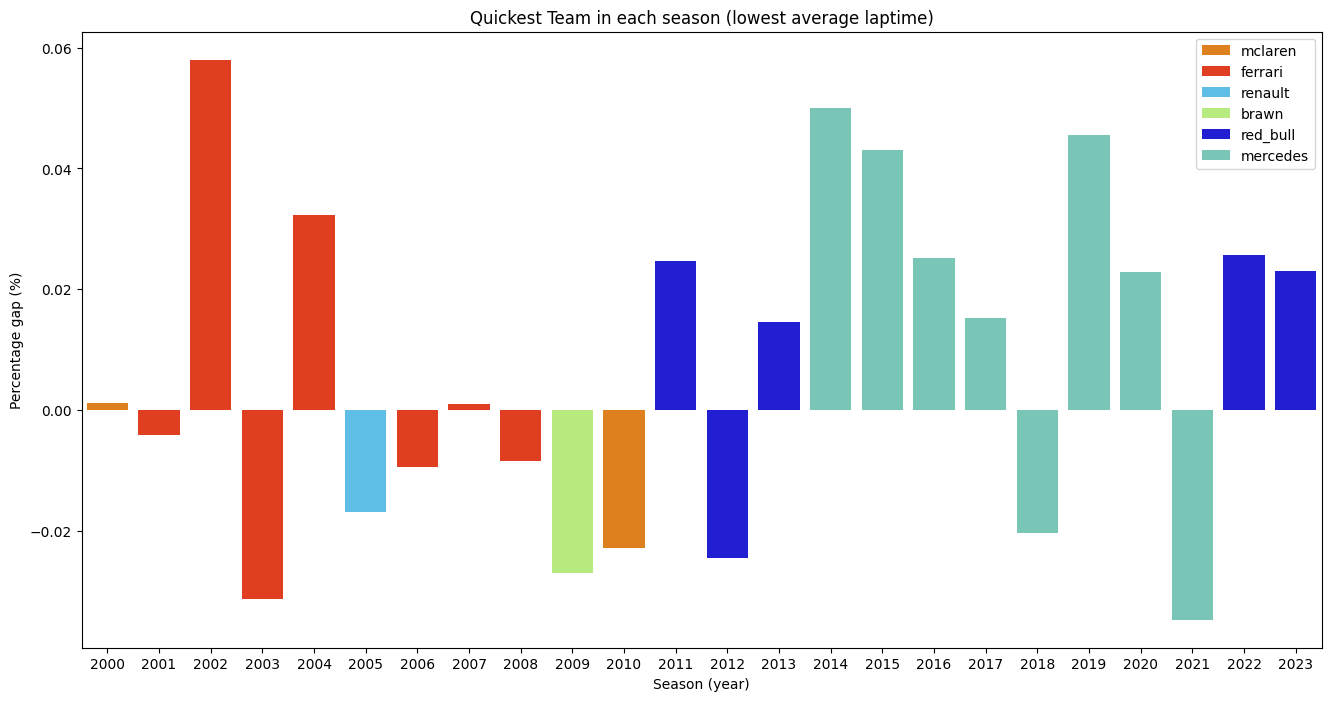

In [20]:
colours = {
    'ferrari': '#FF2800',
    'mclaren': '#FF8000',
    'brawn': '#B8FD6E',
    'red_bull': '#0600EF',
    'mercedes': '#6CD3BF',
    'renault': '#47C7FC'
}

plt.figure(figsize=(16, 8))
sns.barplot(x='year', y='percent', data=fastest_team_year_gap, hue='fastest_team', palette=colours, width=0.8, dodge=False)

plt.xlabel('Season (year)')
plt.ylabel('Percentage gap (%)')
plt.title('Quickest Team in each season (lowest average laptime)')
plt.legend(loc='upper right')
plt.show()